This demo demonstrates how to use integrated gradients in graph convolutional networks to obtain accurate importance estimations for both the nodes and edges. 

In [753]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import os
import time
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
import keras
from keras import layers, optimizers, losses, metrics, Model, regularizers
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph.core.utils import GCN_Aadj_feats_op
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [754]:
data_dir = os.path.expanduser("~/data/cora")

Load the graph from edgelist

In [755]:
edgelist = pd.read_table(os.path.join(data_dir, "cora.cites"), header=None, names=["source", "target"])
edgelist["label"] = "cites"

In [756]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [757]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=140, test_size=None, stratify=node_data['subject'])
val_data, test_data = model_selection.train_test_split(test_data, train_size=500, test_size=None, stratify=test_data['subject'])

In [758]:
from collections import Counter
Counter(train_data['subject'])

Counter({'Rule_Learning': 9,
         'Case_Based': 16,
         'Genetic_Algorithms': 22,
         'Probabilistic_Methods': 22,
         'Neural_Networks': 42,
         'Reinforcement_Learning': 11,
         'Theory': 18})

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [759]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
val_targets = target_encoding.transform(val_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

node_ids = node_data.index
all_targets = target_encoding.transform(
        node_data[["subject"]].to_dict("records")
    )
node_features = node_data[feature_names]
G = sg.StellarGraph(Gnx, node_features=node_features)
print(G.info())


StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



### Creating the GCN model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

To feed data from the graph to the Keras model we need a generator. Since GAT is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and graph adjacency matrix to the model.

In [760]:
generator = FullBatchNodeGenerator(G, func_A_feats=GCN_Aadj_feats_op, filter='localpool')

For training we map only the training nodes returned from our splitter and the target values.

In [761]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

the layer_sizes is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 16/7-dimensional hidden node features at each layer.
activations is a list of activations applied to each layer's output
Arguments such as bias, dropout, kernel_regularizer are internal parameters of the model, execute GCN for details.

In [762]:
layer_sizes = [16, 7]
gcn = GCN(layer_sizes=layer_sizes, activations=["elu", "elu"], generator=generator, bias=True, dropout=0.3,kernel_regularizer=regularizers.l2(5e-4))

In [763]:
# Expose the input and output tensors of the GCN model for node prediction, via GCN.node_model() method:
x_inp, x_out = gcn.node_model()
# Snap the final estimator layer to x_out
x_out = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)


### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `x_out` from the final dense layer

In [764]:
model = keras.Model(inputs=x_inp, outputs=x_out)

In [765]:
model.compile(
    optimizer=optimizers.Adam(lr=0.005),# decay=0.001),
    loss=losses.categorical_crossentropy,
    weighted_metrics=[metrics.categorical_accuracy],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [766]:
N = len(node_ids)
[X, A], y_train, node_mask_train = train_gen.__getitem__(0)
[_, _], y_val, node_mask_val = val_gen.__getitem__(0)

Train the model

In [767]:
history = model.fit(x=[X, A], y=y_train, sample_weight=node_mask_train,
                    batch_size=N, shuffle=False, epochs=20, verbose=2,
                    validation_data=([X, A], y_val, node_mask_val))

Train on 2708 samples, validate on 2708 samples
Epoch 1/20
 - 2s - loss: 4.7507 - weighted_categorical_accuracy: 0.1357 - val_loss: 2.5309 - val_weighted_categorical_accuracy: 0.1120
Epoch 2/20
 - 0s - loss: 2.5995 - weighted_categorical_accuracy: 0.1214 - val_loss: 2.4182 - val_weighted_categorical_accuracy: 0.1280
Epoch 3/20
 - 0s - loss: 2.5027 - weighted_categorical_accuracy: 0.1857 - val_loss: 2.2123 - val_weighted_categorical_accuracy: 0.1640
Epoch 4/20
 - 0s - loss: 2.2023 - weighted_categorical_accuracy: 0.1857 - val_loss: 2.0784 - val_weighted_categorical_accuracy: 0.2560
Epoch 5/20
 - 0s - loss: 2.2184 - weighted_categorical_accuracy: 0.2786 - val_loss: 2.0180 - val_weighted_categorical_accuracy: 0.2920
Epoch 6/20
 - 0s - loss: 1.9835 - weighted_categorical_accuracy: 0.2571 - val_loss: 1.9791 - val_weighted_categorical_accuracy: 0.2940
Epoch 7/20
 - 0s - loss: 2.1239 - weighted_categorical_accuracy: 0.2643 - val_loss: 1.9141 - val_weighted_categorical_accuracy: 0.3540
Epoch 8

In [768]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

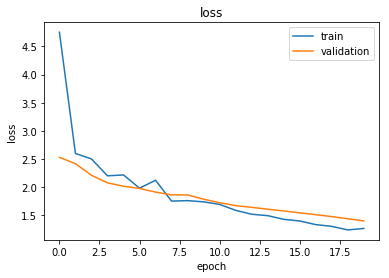

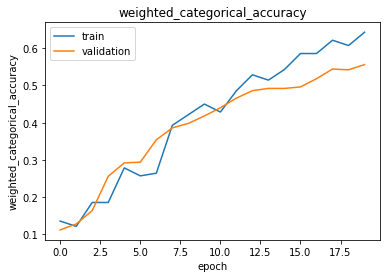

In [769]:
plot_history(history)

Evaluate the trained model on the test set

In [770]:
[_, _], y_test, node_mask_test = generator.flow(test_data.index, test_targets).__getitem__(0)
test_metrics = model.evaluate(x=[X, A], y=y_test, sample_weight=node_mask_test, batch_size=N)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2708/2708 [==============================] - 0s 11us/step

Test Set Metrics:
	loss: 1.4255
	weighted_categorical_accuracy: 0.5527


# Node and link importance via saliency maps

In [771]:
from stellargraph.utils.saliency_maps.integrated_gradients import IntegratedGradients
from stellargraph.utils.saliency_maps.saliency import GradientSaliency

Select the target node whose prediction is to be interpreted

In [772]:
target_idx = 123

Node id of the target node:

In [773]:
target_nid = list(G.nodes())[target_idx]
y_true = all_targets[list(node_ids).index(target_nid)]  # true class of the target node
print(target_nid)

576725


In [774]:
N = len(node_ids)
[X, A], _, _ = train_gen.__getitem__(0)
y_pred = model.predict([X, A], batch_size=N)[target_idx]  # predicted class of the target node
class_of_interest = np.argmax(y_pred)

print("target node id: {}, \ntrue label: {}, \npredicted label: {}".format(target_nid, y_true, y_pred.round(2)))

target node id: 576725, 
true label: [0. 1. 0. 0. 0. 0. 0.], 
predicted label: [0.04 0.51 0.2  0.13 0.02 0.04 0.06]


Get the node feature importance by using integrated gradients

In [775]:
int_grad_saliency = IntegratedGradients(model)

adjacency matrix tensor is sparse


/home/wu061/anaconda3/envs/stellar-research-py35/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


For the parameters of get_node_importance method, X and A are the feature and adjacency matrices, respectively. target_idx is the node of interest and class_of_interest is normally set as the ground truth label of the node. steps indicates the number of integrations. A larger steps give better approximations with higher computational overhead.

In [776]:
integrated_node_importance = int_grad_saliency.get_node_importance(X, A, target_idx, class_of_interest, steps=200)

In [777]:
print('\nintegrated_node_importance', integrated_node_importance.round(2))
print('integrated self-importance of target node {}: {}'.format(target_nid, integrated_node_importance[target_idx].round(2)))


integrated_node_importance [ 5.73  0.45 -0.31 ...  0.    0.    0.  ]
integrated self-importance of target node 576725: -1.51


Check that number of non-zero node importance values matches the number of nodes in target node's 2-hop ego net

In [778]:
G_ego = nx.ego_graph(G, target_nid, radius=len(gcn.activations))

In [779]:
print("\nEgo net of target node {} has {} nodes".format(target_nid, G_ego.number_of_nodes()))
print("integrated_node_importance has {} non-zero elements".format(
    sum([i != 0 for i in integrated_node_importance])))


Ego net of target node 576725 has 176 nodes
integrated_node_importance has 176 non-zero elements


Compute the link importance by integrated gradients. Note that the importance for existing and potential edges are computed differently.

In [780]:
integrate_link_mask = int_grad_saliency.get_integrated_link_masks(X, A, target_idx, class_of_interest, A_baseline = None, steps=200)
print('integrated_link_mask.shape = {}'.format(integrate_link_mask.shape))

integrated_link_mask.shape = (2708, 2708)


Some sanity checks:

In [781]:
print("Number of edges in the graph: {} \nNumber of non-zero elements in A: {}".format(G.number_of_edges(), np.sum(A)))
print("Number of non-zero elements in integrate_link_mask: {}".format(np.count_nonzero(integrate_link_mask)))
print('Number of nodes in the graph: {}'.format(len(G.nodes())))
print('Number of nodes in the ego graph: {}'.format(len(G_ego.nodes())))
edges_in_mask = [(list(G.nodes()).index(x), list(G.nodes()).index(y)) for x, y in G_ego.edges()]
edges_in_mask_importance = np.array([integrate_link_mask[x,y] for x,y in edges_in_mask])
edges_in_mask_importance /= max(edges_in_mask_importance)
#print(G_ego.edges())
involved_nodes = set([x for x in G_ego.nodes()])
edges_in_mask_importance_bk = edges_in_mask_importance

Number of edges in the graph: 5278 
Number of non-zero elements in A: 10556
Number of non-zero elements in integrate_link_mask: 192
Number of nodes in the graph: 2708
Number of nodes in the ego graph: 176


In [782]:
sorted_indices = np.argsort(integrate_link_mask.flatten().reshape(-1))
sorted_indices = np.array(sorted_indices)[0]
integrated_link_importance_rank = [(int(k/N), k%N) for k in sorted_indices[::-1]]
topk = 10
print('Top {} most important links by integrated gradients are {}'.format(topk, integrated_link_importance_rank[-topk:]))

Top 10 most important links by integrated gradients are [(0, 108), (0, 165), (0, 131), (0, 92), (0, 54), (0, 153), (0, 72), (124, 118), (0, 2374), (0, 5)]


In [783]:
nx.set_node_attributes(G_ego, values={x[0]:{'subject': x[1]} for x in node_data['subject'].items()})

In the following, we plot the link and node importance (computed by integrated gradients) of the nodes within the ego graph of the target node. 

For nodes, the shape of the node indicates the positive/negative importance the node has. 'round' nodes have positive importance while 'diamond' nodes have negative importance. The size of the node indicates the value of the importance, e.g., a large diamond node has higher negative importance. 

For links, the color of the link indicates the positive/negative importance the link has. 'red' links have positive importance while 'blue' links have negative importance. The width of the link indicates the value of the importance, e.g., a thicker blue link has higher negative importance.

/home/wu061/anaconda3/envs/stellar-research-py35/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


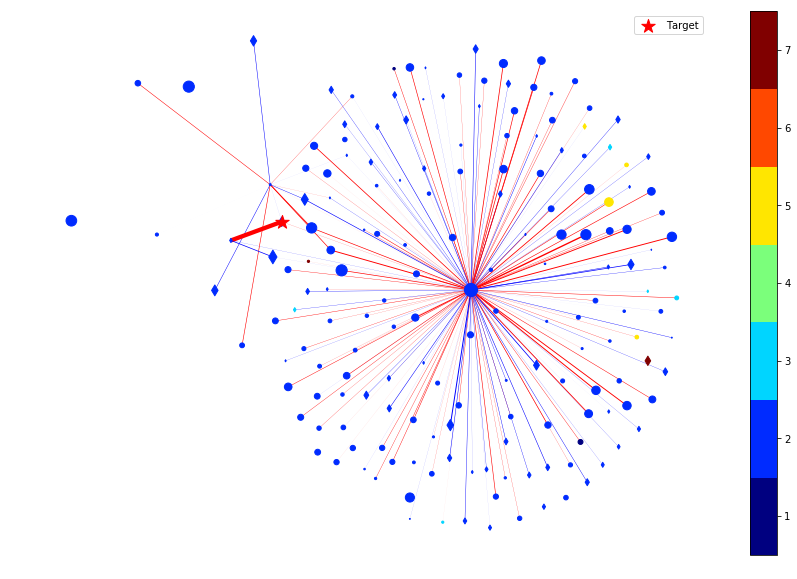

In [784]:
nodes = G_ego.nodes()
colors = pd.DataFrame([v[1]['subject'] for v in G_ego.nodes(data=True)], index=nodes, columns=['subject'])
colors = np.argmax(target_encoding.transform(colors.to_dict('records')), axis=1) + 1

fig, ax = plt.subplots(1, 1, figsize=(15, 10));
pos = nx.spring_layout(G_ego)
# Draw ego as large and red
node_sizes = [integrated_node_importance[list(G.nodes()).index(k)] for k in G_ego.nodes()]
node_shapes = ['o' if integrated_node_importance[list(G.nodes()).index(k)] > 0 else 'd' for k in G_ego.nodes()]
positive_colors, negative_colors = [], []
positive_node_sizes, negative_node_sizes = [], []
positive_nodes, negative_nodes = [], []
#node_size_sclae is used for better visualization of nodes
node_size_scale = 30
for k in range(len(node_shapes)):
    if list(nodes)[k] == target_idx:
        continue
    if node_shapes[k] == 'o':
        positive_colors.append(colors[k])
        positive_nodes.append(list(nodes)[k])
        positive_node_sizes.append(node_size_scale*node_sizes[k])

    else:
        negative_colors.append(colors[k])
        negative_nodes.append(list(nodes)[k])
        negative_node_sizes.append(node_size_scale*abs(node_sizes[k]))



nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=positive_nodes, node_color=positive_colors, cmap=cmap, node_size=positive_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='o')
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=negative_nodes, node_color=negative_colors, cmap=cmap, node_size=negative_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='d')
nx.draw_networkx_nodes(G_ego, pos, nodelist=[target_nid], node_size=200, node_shape='*',node_color='r',label="Target")
cmap = plt.get_cmap('jet', np.max(colors)-np.min(colors)+1)

edges = G_ego.edges()
#link_width_scale is used for better visualization of links
link_width_scale = 5
weights = [integrate_link_mask[list(G.nodes()).index(u),list(G.node()).index(v)] for u,v in edges]
edge_colors = ['red' if integrate_link_mask[list(G.nodes()).index(u),list(G.node()).index(v)] > 0 else 'blue' for u,v in edges]

ec = nx.draw_networkx_edges(G_ego, pos, edge_color=edge_colors,  width = weights)
plt.legend()
plt.colorbar(nc, ticks=np.arange(np.min(colors),np.max(colors)+1))
plt.axis('off')
plt.show()

We then remove the node or edge in the ego graph one by one and check how the prediction changes. By doing so, we can obtain the ground truth importance of the nodes and edges. Comparing the following figure and the above one can show the effectiveness of integrated gradients as the importance approximations are relatively consistent with the ground truth.

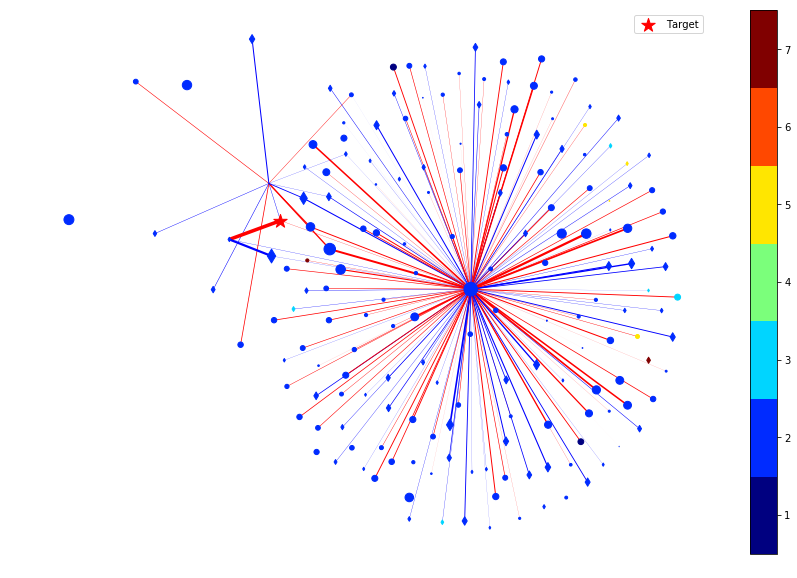

In [788]:
X_bk = deepcopy(X)
edges = [(list(G.nodes()).index(u),list(G.node()).index(v)) for u,v in G_ego.edges()]
nodes = [list(G.node()).index(v) for v in G_ego.nodes()]
clean_prediction = model.predict([X, A], batch_size=N)[target_idx]
groud_truth_edge_importance = np.zeros(A.shape, dtype = 'float')
groud_truth_node_importance = []

for node in nodes:
    if node == target_idx:
        groud_truth_node_importance.append(0)
        continue
    X = deepcopy(X_bk)
    #we set all the features of the node to zero to check the ground truth node importance.
    X[node, :] = 0
    predict_after_perturb = model.predict([X, A], batch_size=N)[target_idx]  
    prediction_change = clean_prediction[1] - predict_after_perturb[1]
    groud_truth_node_importance.append(prediction_change)

node_shapes = ['o' if groud_truth_node_importance[k] > 0 else 'd' for k in range(len(nodes))]
positive_colors, negative_colors = [], []
positive_node_sizes, negative_node_sizes = [], []
positive_nodes, negative_nodes = [], []
#node_size_scale is used for better visulization of nodes
node_size_scale = 8e3

for k in range(len(node_shapes)):
    if nodes[k] == target_idx:
        continue
    if node_shapes[k] == 'o':
        positive_colors.append(colors[k])
        positive_nodes.append(list(G.nodes())[nodes[k]])
        positive_node_sizes.append(node_size_scale*groud_truth_node_importance[k])
    else:
        negative_colors.append(colors[k])
        negative_nodes.append(list(G.nodes())[nodes[k]])
        negative_node_sizes.append(node_size_scale*abs(groud_truth_node_importance[k]))
        
X = deepcopy(X_bk)
for edge in edges:
    original_val = A[edge[0], edge[1]]
    if original_val == 0:
        continue
    #we set the weight of a given edge to zero to check the ground truth link importance
    A[edge[0], edge[1]] = 0
    predict_after_perturb = model.predict([X, A], batch_size=N)[target_idx]  
    groud_truth_edge_importance[edge[0], edge[1]] = (predict_after_perturb[1] - clean_prediction[1])/(0 - 1)
    A[edge[0], edge[1]] = original_val

fig, ax = plt.subplots(1, 1, figsize=(15, 10));
# Draw ego as large and red
nx.draw_networkx_nodes(G_ego, pos, nodelist=[target_nid], node_size=200, node_color='r', node_shape='*', label="Target")
cmap = plt.get_cmap('jet', np.max(colors)-np.min(colors)+1)
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=positive_nodes, node_color=positive_colors, cmap=cmap, node_size=positive_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='o')
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=negative_nodes, node_color=negative_colors, cmap=cmap, node_size=negative_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='d')
edges = G_ego.edges()
#link_width_scale is used for better visulization of links
link_width_scale = 2e2
weights = [link_width_scale*groud_truth_edge_importance[list(G.nodes()).index(u),list(G.node()).index(v)] for u,v in edges]

edge_colors = ['red' if groud_truth_edge_importance[list(G.nodes()).index(u),list(G.node()).index(v)] > 0 else 'blue' for u,v in edges]

ec = nx.draw_networkx_edges(G_ego, pos, edge_color=edge_colors, width = weights)
plt.legend()
plt.colorbar(nc, ticks=np.arange(np.min(colors),np.max(colors)+1))
plt.axis('off')
plt.show()

By comparing the above two figures, one can see that the integrated gradients are quite consistent with the brute-force approach. The main benefit of using integrated gradients is about scalability. The gradient operations are very efficient to compute on deep learning frameworks with the parallism provided by GPUs. Also, integrated gradients can give the importance of each features beyond the nodes. Achiving this by brute-force approch is often non-trivial. 